<a href="https://colab.research.google.com/github/valentingorce/tp_centrale/blob/main/Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Information Retrieval
## Introduction to search engines

### DAY 2: Teacher version
### Implementing a search engine

The goal of this second session is to implement a first architecture of a search engine on the previously introduced dataset (stackexchange-datascience). If you missed the first session or if you did not saved the dataset, please reload the first session's notebook to download it. 

If you need some ifnormation about the dataset, it should be available here : https://archive.org/details/stackexchange

The notebook is divided into several steps:
-	Implement the indexation
-	Implement the search method
-	Define a ranking strategy and implement it
-	Suggest some improvements of the search engine



## Initialisation

In [1]:
# !pip install ttable

In [2]:
import pandas as pd
import re
import os
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from tt import BooleanExpression
from itertools import product

In [3]:
# # Only if you use Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
DATA_PATH = 'datascience.stackexchange.com/'


**Important :**

An Excel file for testing the evaluation part is available in the gitlab repo : evaluation_search_engine_post_queries_ranking_EI_CS.xlsx

If you work on Colab, we advice you to push it directly on your Google Drive directory.

# Implement the indexation
As you might already know, for a search engine to work properly an index of the documents must be created. Here we will keep it in python, and try to use only common libraries to keep it simple.

Once created, the index will be used to match the query with the documents. As a result, there are several ways to build an index, using statistical, boolean, semantic indexation...

First of, let's make a naive one that will consist in breaking down each document into a set of the words it contains.

In [5]:
def extract_words(text):
  return text.split(' ')



In [6]:

# test
s = "The cat is sat on the mat. The dog is laid on the mat."
words = extract_words(s)
assert sorted(words) == ['The', 'The', 'cat', 'dog', 'is', 'is', 'laid', 'mat.', 'mat.', 'on', 'on', 'sat', 'the', 'the']

As you may notice, there are several problems with the previous implementation. First, "The" and "the" aren't considered the same, the "." is kept at the the end of "mat." as any other punctuation character... 

Re-implement this function with some basic preprocessing to avoid these issues.

In [7]:
# problems : First, "The" and "the" aren't considered the same, the "." is kept at the the end of "mat." as any other punctuation character... 
def extract_words(text:str)->list:
  text = text.lower()
  text = re.sub(r'[^\w\s]','',text)
  return text.split(' ')

In [8]:
# test
print(sorted(extract_words(s)))
assert sorted(extract_words(s))==['cat', 'dog', 'is', 'is', 'laid', 'mat', 'mat', 'on', 'on', 'sat', 'the', 'the', 'the', 'the']

['cat', 'dog', 'is', 'is', 'laid', 'mat', 'mat', 'on', 'on', 'sat', 'the', 'the', 'the', 'the']


Now you sould be able to create your index table. For now we will just make a dataframe with two columns: [raw_text, words].

In [9]:
import pandas as pd
def index_docs(docs:list[str])->pd.DataFrame:
  df = pd.DataFrame(docs,columns=['raw_text'])
  df['words'] = df['raw_text'].apply(extract_words)
  return df

In [10]:
# test

L = [s, "Hello World!", "Goodbye", "How are you?"]

index_docs(L)

,raw_text,words
0,The cat is sat on the mat. The dog is laid on ...,"[the, cat, is, sat, on, the, mat, the, dog, is..."
1,Hello World!,"[hello, world]"
2,Goodbye,[goodbye]
3,How are you?,"[how, are, you]"


Now, let's try it on the dataset:

In [11]:
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")
posts

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ClosedDate,ContentLicense,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName,FavoriteCount
0,5,1,2014-05-13T23:58:30.457,9,898.0,<p>I've always been interested in machine lear...,5.0,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,...,2014-05-14T14:40:25.950,CC BY-SA 3.0,NaN,NaN,None,NaN,None,None,None,NaN
1,7,1,2014-05-14T00:11:06.457,4,478.0,"<p>As a researcher and instructor, I'm looking...",36.0,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,...,2014-05-14T08:40:54.950,CC BY-SA 3.0,10.0,97.0,2014-05-16T13:45:00.237,NaN,None,None,None,NaN
2,9,2,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,2014-05-14T00:36:31.077,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,5.0,None,None,None,NaN
3,10,2,2014-05-14T00:53:43.273,13,NaN,"<p>One book that's freely available is ""The El...",22.0,2014-05-14T00:53:43.273,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,7.0,None,None,None,NaN
4,14,1,2014-05-14T01:25:59.677,26,1901.0,<p>I am sure data science as will be discussed...,66.0,2020-08-16T13:01:33.543,Is Data Science the Same as Data Mining?,<data-mining><definitions>,...,None,CC BY-SA 3.0,29.0,322.0,2014-06-17T16:17:20.473,NaN,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75722,119962,1,2023-03-04T20:06:06.820,0,8.0,<p>I am implementing a neural network of arbit...,147597.0,2023-03-04T20:22:12.523,Back Propagation on arbitrary depth network wi...,<neural-network><backpropagation>,...,None,CC BY-SA 4.0,NaN,147597.0,2023-03-04T20:22:12.523,NaN,None,None,None,NaN
75723,119963,1,2023-03-04T20:12:19.677,0,10.0,<p>I am using KNN for a regression task</p>\n<...,147598.0,2023-03-04T20:12:19.677,Evaluation parameter in knn,<regression><k-nn>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN
75724,119964,1,2023-03-05T00:14:12.597,0,7.0,<p>I have developed a small encoding algorithm...,44581.0,2023-03-05T00:14:12.597,Can I use zero-padded input and output layers ...,<deep-learning><convolutional-neural-network>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN
75725,119965,1,2023-03-05T00:43:12.213,0,5.0,"<p>To my understanding, optimizing a model wit...",84437.0,2023-03-05T00:43:12.213,Why does cross validation and hyperparameter t...,<cross-validation><hyperparameter-tuning>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN


For our first version of the indexation mechanism, we will simply use the "body" of the posts. To have a better search engine, the title and other metadata aswell could be used aswell. Finally, not all the XML files have a "body" feature, so for the search engine to retrieve information from any of the files you will need to implement another way to index.

But first, let's start with "body". There is more to preprocess than before, indeed, there are html tags such as "<p>" for instance. They are not useful for us, because users won't use them in their queries. So we first need to remove them.

In [12]:
def remove_tags(text:str)->str:
  return re.sub(r'<[^>]+>', '', text)


In [13]:
# test
remove_tags('<p>Hello World!\nI am making a search engine.<p>')

'Hello World!\nI am making a search engine.'

In [14]:
clean_posts = posts[['Id','Body']]
clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
clean_posts

/tmp/ipykernel_19985/2440634092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)


,Id,Body,Clean Body
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...
...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task\nIt's lik...
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k..."


In [15]:
clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words)
clean_posts

/tmp/ipykernel_19985/2163112268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words)


,Id,Body,Clean Body,words
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...,"[ive, always, been, interested, in, machine, l..."
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo...","[as, a, researcher, and, instructor, im, looki..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu...","[not, sure, if, this, fits, the, scope, of, th..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme...","[one, book, thats, freely, available, is, the,..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...,"[i, am, sure, data, science, as, will, be, dis..."
...,...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...,"[i, am, implementing, a, neural, network, of, ..."
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task\nIt's lik...,"[i, am, using, knn, for, a, regression, task\n..."
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...,"[i, have, developed, a, small, encoding, algor..."
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k...","[to, my, understanding, optimizing, a, model, ..."


## Zipf Law

A way of analyzing a corpus is to draw the zipf law

In [16]:
# Draw Zipf Law on the Posts Corpus
import matplotlib.pyplot as plt
# get word count for each word
word_count = clean_posts['words'].explode().value_counts()
word_count

                                           2051547
the                                         497900
to                                          271649
a                                           226675
of                                          212782
                                            ...   
modelcheckpointfilepathbest_weightshdf5          1
modeauto\ncheckpointer                           1
min_delta1e8                                     1
optimizeropt\nmonitor                            1
004946931214392558\n\nam                         1
Name: words, Length: 630509, dtype: int64

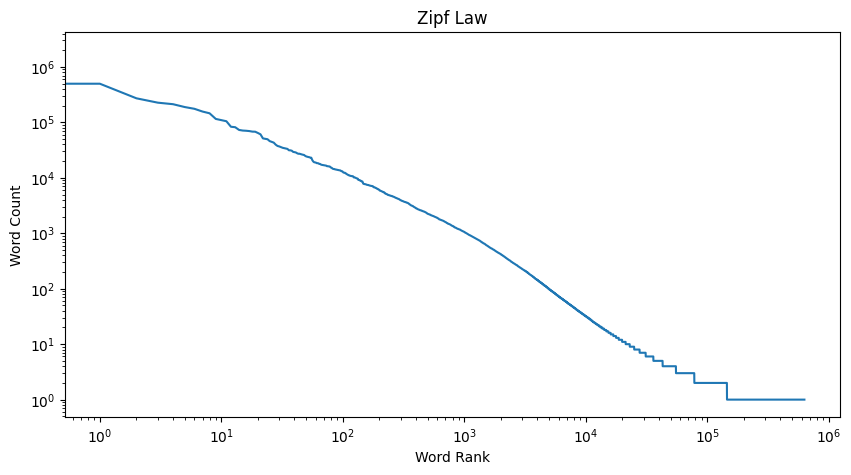

In [17]:
plt.figure(figsize=(10,5))
plt.plot(word_count.values)
plt.xlabel('Word Rank')
plt.ylabel('Word Count')
# log-log scale
plt.yscale('log')
plt.xscale('log')
plt.title('Zipf Law')
plt.show()

## Inverted Index

Now, we want to go further on the indexing and build an inverted index. Inverted index is a dictionary where the keys are the words of the vocabulary and the values are the documents containing these words. Reducing the size of the vocabulary is a relevant first step when building an inverted index. Here, we will focus on the creation of the index, we leave you the optimisation steps :)

In [18]:
def create_index(posts:pd.DataFrame):
  index = {}
  for _, row in posts.iterrows():
    for word in row['words']:
      if word in index:
        index[word].add(row['Id'])
      else:
        index[word] = {row['Id']}
  return index

In [19]:
# inverted_index = create_index(clean_posts.iloc[0:5000])
# # save index to pickle
# import pickle
# with open('inverted_index.pickle', 'wb') as handle:
#     pickle.dump(inverted_index, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [20]:
# load index from pickle
import pickle
inverted_index = {}
with open('inverted_index.pickle', 'rb') as handle:
    inverted_index = pickle.load(handle)

#### Well Done, you've indexed the dataset! 
Don't hesitate to save your indexes in txt or pickle file

---
# Implement the search method

A naive method would be to count the number of words in common between the query and each posts. Then to rank the posts you could directly select the post who maximize the number of common words. Let's implement this approach :

In [21]:
# Implement the word_in_index function 
# Inputs : a word (str) & a list of words
# Output : pandas series of 1 if the word is in the list, else 0

def word_in_index(word, word_list_index):
  return pd.Series([1 if word in words else 0 for words in word_list_index])

# test
print(word_in_index('cat', [['cat', 'dog'], ['cat', 'mouse'], ['dog', 'mouse']]))


0    1
1    1
2    0
dtype: int64


In [22]:
# Implement the function which run through a pandas series and count the number of word in common
# Use extract_words method, apply method with word_in_index function
# Inputs : the query (str) & pandas series of strings
# Output : Pandas series counting the number of common words between the query and each string in word_serie

def count_common_words(query, word_serie):
  query_words = extract_words(query)
  return word_serie.apply(lambda x: sum(word_in_index(word, [x]) for word in query_words))

# test
print(count_common_words('cat dog', pd.Series([['cat', 'dog'], ['cat', 'mouse'], ['dog', 'mouse']])))



   0
0  2
1  1
2  1


In [23]:

def rank_top_query(query, df, top=5):
  # get the number of common words between the query and each document
  common_words = count_common_words(query, df['words'])
  # sort the documents by number of common words
  sorted_common_words = common_words.sort_values(by=0, ascending=False)
  # return the top documents
  return df.iloc[sorted_common_words.index[0:top]]


In [24]:
results = rank_top_query(query="testing the query in python", df=clean_posts, top=5) # prends 1min30 pour tourner


In [25]:
# print(results)
for _, row in results.iterrows():
    print(row['Clean Body'])
    print('-------------------')

tl;dr: They markedly differ in many aspects and I can't think Redshift will replace Hadoop.  

-Function
You can't run anything other than SQL on Redshift. Perhaps most importantly, you can't run any type of custom functions on Redshift. In Hadoop you can, using many languages (Java, Python, Ruby.. you name it). For example, NLP in Hadoop is easy, while it's more or less impossible in Redshift. I.e. there are lots of things you can do in Hadoop but not on Redshift. This is probably the most important difference.

-Performance Profile
Query execution on Redshift is in most cases significantly more efficient than on Hadoop. However, this efficiency comes from the indexing that is done when the data is loaded into Redshift (I'm using the term indexing very loose here). Therefore, it's great if you load your data once and execute multiple queries, but if you want to execute only one query for example, you might actually lose out in performance overall.

-Cost Profile
Which solution wins ou

In [26]:
# pros:
# - easy to implement
# - fast to compute (1min30 par requete, bon...)
# cons:
# - gives the same weight to all words, even common words like "the" or "is"
# - doesn't take into account the order of the words in the query
# - doesn't take into account the order of the words in the documents
# - doesn't take into account the number of times a word appears in a document
# - doesn't take into account the number of times a word appears in the corpus


Testez plusieurs requêtes et critiquez les résultats obtenus.

Quels sont les pros and cons de cette méthodes. Vous l'indiquerez sur le rapport avec vos réflexions pour l'améliorer.

Next, you have to implement the first improvements you find in the search method to get most relevant results 

In [27]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words =  stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/himmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:

def remove_stop_words(l_txt: list) -> list:
    return [word for word in l_txt if word not in stop_words]

# test
print(remove_stop_words(['the', 'cat', 'is', 'on', 'the', 'mat'])) # ['cat', 'mat']

['cat', 'mat']


## Boolean Search

Thanks to the ttable library, implement a boolean search method

In [29]:
from tt import BooleanExpression

def boolean_search(query, df=clean_posts):
  # get the words in the query
  expression =  BooleanExpression(query)
  # get the posts whose clean body that satisfy the expression
  symbols = expression.symbols
  # for each post and for each symbol, check if the symbol is in the post, then evaluate the expression
  bools = df['Clean Body'].apply(lambda x: [symbol in x for symbol in symbols]).apply(lambda x: expression.evaluate(**dict(zip(symbols,x))))
  # return all documents that satisfy the expression
  return df.iloc[bools[bools].index]

  


  # return the top documents

results = boolean_search('java AND NOT python')

for _, row in results[0:5].iterrows():
    print(row['Clean Body'])
    print('-------------------')

This isn't a full solution, but you may want to look into OrientDB as part of your stack. Orient is a Graph-Document database server written entirely in Java. 

In graph databases, relationships are considered first class citizens and therefore traversing those relationships can be done pretty quickly. Orient is also a document database which would allow you the kind of schema-free architecture it sounds like you would need. The real reason I suggest Orient, however, is because of its extensiblity. It supports streaming via sockets, and the entire database can be embedded into another application. Finally, it can be scaled efficiently and/or can work entirely through memory. So, with some Java expertise, you can actually run your preset queries against the database in memory.

We are doing something similar. In creating an app/site for social science research collaboration, we found ourselves with immensely complex data models. We ended up writing several of the queries using the Greml

## Probabilistic search

Implement the MIB or BM25 method of searching

In [30]:
print(clean_posts)

           Id                                               Body  \
0           5  <p>I've always been interested in machine lear...   
1           7  <p>As a researcher and instructor, I'm looking...   
2           9  <p>Not sure if this fits the scope of this SE,...   
3          10  <p>One book that's freely available is "The El...   
4          14  <p>I am sure data science as will be discussed...   
...       ...                                                ...   
75722  119962  <p>I am implementing a neural network of arbit...   
75723  119963  <p>I am using KNN for a regression task</p>\n<...   
75724  119964  <p>I have developed a small encoding algorithm...   
75725  119965  <p>To my understanding, optimizing a model wit...   
75726  119966  <p>I'm working with a dataset of cars, contain...   

                                              Clean Body  \
0      I've always been interested in machine learnin...   
1      As a researcher and instructor, I'm looking fo...   
2  

In [31]:
def proba_search(query, df=clean_posts, top=5):
  # each document get a score
  # OKAPI model (BM25)
  # print('query : ', query)
  # print('top : ', top)
  query_words = extract_words(query)
  k1 = 1.2
  b = 0.75
  k3 = 1000
  # average length of a document
  m = df['Clean Body'].apply(lambda x: len(x)).mean()
  N = len(df)
  RSV_score = {}
  # for each post in df :
  for _, row in df.iterrows():
    # sum over all words in the query and in the post
    # length of the post
    Ld = len(row['Clean Body'])
    # term frequency in the query
    def tf(word):
      return sum([1 for w in query_words if w == word])
    def d_f(word):
      if word not in inverted_index:
        #print(word)
        return 0
      else:
        return len(inverted_index[word])
    RSV_score[row['Id']] = sum([(k1+1)*tf(word)/(k1*((1-b)+b*Ld/m)+tf(word))*(k3+1)*tf(word)/(k3+tf(word))*np.log((N-d_f(word)+0.5)/(d_f(word)+0.5)) for word in query_words if word in row['words']])
  # return the top Ids of the posts from RSV
  sorted_keys = sorted(RSV_score, key=RSV_score.get, reverse=True) # the Id column in the best order
  # the values of sorted_keys are values of df["Id"]
  # return the top documents in the same order as sorted_keys
  new_df = df.copy()
  new_df['RSV_score'] = new_df['Id'].apply(lambda x: RSV_score[x])
  new_df = new_df.sort_values(by='RSV_score', ascending=False)
  return new_df[new_df["Id"].isin(sorted_keys[0:top])]


In [32]:
# test
print("begin")
results = proba_search('measure performance for multi classification model',top=len(clean_posts))
# reset index


begin


In [33]:
print(results)

# for _, row in results.iterrows():
#     print(row['Clean Body'])
#     print('-------------------')

          Id                                               Body  \
42084  65228  <p>AUC - ROC curve is a performance measuremen...   
29920  46296  <p>Confusion matrix is generally not considere...   
60685  96726  <p>Though it does not exactly measure uncertai...   
1944    5233  <p>Please I want to know if there is any SVM R...   
51735  80531  <p>I'm interested in <a href="https://debug-ml...   
...      ...                                                ...   
23111  36656  <p>I am wondering why do we use scaling on tra...   
23113  36658  <p>train and test datasets should have no over...   
23115  36661  <p>I'm trying to mine some data with Rstudio, ...   
55729  87556  <p>It seems that your target variable (died or...   
0          5  <p>I've always been interested in machine lear...   

                                              Clean Body  \
42084  AUC - ROC curve is a performance measurement f...   
29920  Confusion matrix is generally not considered a...   
60685  Though i

Compare the naive method with your improvements and the boolean and probabilistic search. (report)



---



---




# Evaluate the Search

Now you implement multiple search methods and you're able to improve it. You have to define metric to compare it objectively.



We ask you to implement NDCG (Normalized Discounted Cumulative Gain) from few queries we implement on a dozen of post. We already defined the values of relevance judgement in the xlsx file : . The final score will be the mean quadratic error of the queries.


Explication for the xlsx file :

We propose you a Excel file with some posts and a mesure of relevancy for the queries

- First column is the post Id,
- Columns starting by query are the queries you have to test.
- The values in this columns are the rank of relevancy of the post in regard with the query.
- The missing values indicates you should not take into account the post


You will have to criticize this metric and your result in the report. Then you will have to propose some improvements. 

Thereafter in this week, you will have to compare your different search engines.

In [34]:
# Read Relevancy CSV
df_relevancy = pd.read_excel("evaluation_search_engine_post_queries_ranking_EI_CS.xlsx")
df_relevancy.head()

,PostId,Title,First Sentence,Query 1 : mesure performance for multiclassification model,Query 2 : draw neural network,Query 3 : neural network layers,Query 4 : how sklearn working,Query 5 : treat categorical data
0,6107,What are deconvolutional layers?,I recently read Fully Convolutional Networks f...,NaN,NaN,1.0,NaN,NaN
1,15989,Micro Average vs Macro average Performance in ...,I am trying out a multiclass classification se...,1.0,NaN,NaN,NaN,NaN
2,13490,How to set class weights for imbalanced classe...,I know that there is a possibility in Keras wi...,3.0,NaN,NaN,NaN,NaN
3,12321,What's the difference between fit and fit_tran...,I do not understand the difference between the...,NaN,NaN,NaN,1.0,3.0
4,22,K-Means clustering for mixed numeric and categ...,My data set contains a number of numeric attri...,NaN,NaN,NaN,5.0,2.0


In [38]:
from sklearn.metrics import ndcg_score

    """
    Calculates the NDCG (Normalized Discounted Cumulative Gain) score for each query in the given relevance dataframe
    using the specified search method.

    Parameters:
    -----------
    df_relevancy : pandas.DataFrame
        A dataframe containing the relevance scores for each post and query.
        The first column should contain the post IDs, and the remaining columns from the 4th should be named 'query X',
        where X is the query number starting from 1.
        The values in the columns should be the relevance scores for each post with respect to the corresponding query.
    method : function
        The search method to use for retrieving the top documents for each query.
        The function should take a query string as input and return a pandas.DataFrame containing the top documents.
    top : int, optional
        The number of top documents to retrieve for each query.
        The default value is the total number of posts in the dataset.

    Returns:
    --------
    dict
        A dictionary containing the NDCG score for each query.
        The keys are the query numbers starting from 1, and the values are the corresponding NDCG scores.
    """


def get_ndcg_scores(df_relevancy,method=proba_search,top=len(clean_posts)):
    # for each PostId in the relevancy dataframe, get the rank of the post according to the method
    querys = {}
    for i in range(3, 8):
        querys[i] = df_relevancy.columns[i][10:]
    method_results = {}
    for i in range(3, 8):
        method_results[i] = method(query=querys[i],top=top)
        #print(method_results[i].head())
    # get the score of each post according to the method
    rel_preds = {}
    for i in range(3, 8):
        # the rankings of the posts in PostId
        rel_preds[i] = [list(method_results[i]["Id"]).index(x) if x in method_results[i]["Id"] else top for x in df_relevancy['PostId']]
        #print(rel_preds[i])
    rel_trues = {}
    for i in range(3, 8):
        # the rankings of the posts
        rel_trues[i] = df_relevancy[df_relevancy.columns[i]].tolist()
        #print(rel_trues[i])
        rel_trues[i] = [top if np.isnan(x) else x for x in rel_trues[i]]

    # calculate the ndcg score for each query
    ndcg_scores = {}
    for i in range(3, 8):
        ndcg_scores[i] = ndcg_score([rel_trues[i]], [rel_preds[i]])
    return ndcg_scores
    

print(get_ndcg_scores(df_relevancy,method=proba_search))
   
# rel_pred = 


# table of ndcg for each query
# ndcg_table = pd.DataFrame(columns=['Query', 'NDCG'])
# for i in range(4, 8):
  # ndcg_table = ndcg_table.append({'Query': f'Query {i-3}', 'NDCG': calculate_ndgc(df_relevancy.columns[i])}, ignore_index=True)

# print(ndcg_table)

[52280, 61610, 59518, 2972, 34327, 1218, 43356, 61420, 58965, 57523, 8702, 32997]
[50229, 55117, 54897, 57351, 52459, 6, 2086, 55640, 3639, 3495, 6685, 50923]
[9364, 55648, 54954, 57381, 52656, 4432, 2843, 56236, 4871, 4690, 8066, 51285]
[20648, 63475, 30767, 32595, 38804, 68232, 36677, 4941, 28784, 40636, 13493, 43362]
[58137, 14438, 60138, 201, 444, 61764, 19335, 4704, 60937, 57379, 55025, 388]
[nan, 1.0, 3.0, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan, 2.0, 4.0, nan, 1.0, 3.0, 5.0, nan]
[1.0, nan, nan, nan, nan, 5.0, 2.0, nan, 4.0, 3.0, 6.0, nan]
[nan, nan, nan, 1.0, 5.0, nan, nan, 2.0, nan, 3.0, 4.0, 7.0]
[nan, nan, nan, 3.0, 2.0, nan, nan, nan, nan, nan, 4.0, 1.0]
{3: 0.7907373106010506, 4: 0.9999997278906044, 5: 0.999999024471228, 6: 0.8753479921847879, 7: 0.9860441124725677}
